In [102]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
import matplotlib.pyplot as plt

In [64]:
from speedml import Speedml
sml = Speedml('input/train.csv', 
              'input/test.csv', 
              target = 'SalePrice',
              uid = 'Id')
sml.shape()

'train (1460, 80) | test (1459, 79)'

In [65]:
sml.configure('overfit_threshold',  sml.np.sqrt(sml.train.shape[0]) / sml.train.shape[0])
sml.configure('outpath',  "/")
sml.configure('high_cardinality',  30)

{'high_cardinality': 10,
 'outlier_threshold': 3,
 'outpath': 'output/',
 'overfit_threshold': 0.026171196129510684,
 'unique_ratio': 80}

{'high_cardinality': 10,
 'outlier_threshold': 3,
 'outpath': '/',
 'overfit_threshold': 0.026171196129510684,
 'unique_ratio': 80}

{'high_cardinality': 30,
 'outlier_threshold': 3,
 'outpath': '/',
 'overfit_threshold': 0.026171196129510684,
 'unique_ratio': 80}

In [66]:
eda_result_df = sml.eda()
eda_result_df

,Results,Observations
Speedml Release,v0.9.3,Visit https://speedml.com for release notes.
Outliers Upper,"[LotArea, BsmtFinSF2, LowQualFinSF, BsmtHalfBa...",Positive skew (> 3). Use feature.outliers(upper).
Shape,"train (1460, 80) | test (1459, 79)",
Numerical Ratio,46%,Aim for 100% numerical.
Numerical High-cardinality,"[LotFrontage, LotArea, YearBuilt, YearRemodAdd...",(>30) categories. Use feature.density
Numerical Categorical,"[MSSubClass, OverallQual, OverallCond, LowQual...",Use plot.ordinal.
Text Categorical,"[Fence, FireplaceQu, CentralAir, MiscFeature, ...",Use feature.labels or feature.mapping.
Target Analysis (SalePrice),Pre-process.,Dimensionality reduction?


In [67]:
print(type(sml.train))
sml.train.head()

<class 'pandas.core.frame.DataFrame'>


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Deal with Outliers 

 Rules of thunmbs here:
 
* Check the relationship b.t. the target (SalePrice) the outlier feature from the eda result
* For a specific feature, if there are extreme values along that feature (far different from the most data on that feature axis), we can check if it could potentially provide information gain. If yes, keep it; otherwise drop it.
* Information gain here: not entropy kind of stuff, but very simple check: How those seemingly outliers correlates to the target feature (SalePrice) ? Or can they help to narrow down or restrain the SalePrice's range ? 

>show the outlier columns, types, and r value w.r.t the SalePrice

In [68]:
from scipy.stats import pearsonr 

In [69]:
outliers_col = eda_result_df['Results'][1]
before_ol_remove_df = pd.DataFrame ({
            'col name': outliers_col, 
            'type': [sml.train[col].dtype for col in outliers_col],
            'r-val': [pearsonr(sml.train[col], sml.train['SalePrice'])[0] for col in outliers_col]
        })
before_ol_remove_df

,col name,r-val,type
0,LotArea,0.263843,int64
1,BsmtFinSF2,-0.011378,int64
2,LowQualFinSF,-0.025606,int64
3,BsmtHalfBath,-0.016844,int64
4,KitchenAbvGr,-0.135907,int64
5,EnclosedPorch,-0.128578,int64
6,3SsnPorch,0.044584,int64
7,ScreenPorch,0.111447,int64
8,PoolArea,0.092404,int64
9,MiscVal,-0.021190,int64


In [70]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

### check **LotArea**

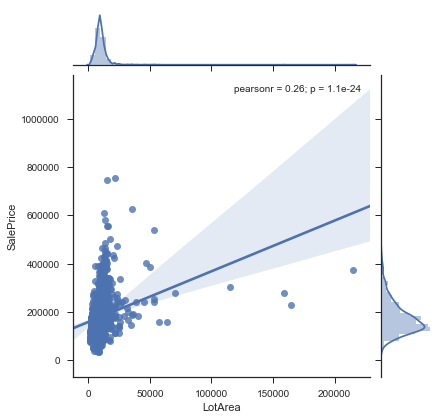

In [71]:
sns.jointplot(x='LotArea', y="SalePrice", data=sml.train, kind="reg") 

if we look into for LotArea's seemingly outliers, say where LotArea > 52000

check outlier precentage = 0.685 %


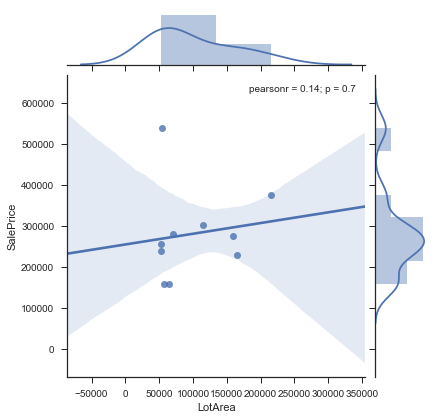

In [72]:
temp_df = sml.train[sml.train['LotArea'] > 52000]
print('check outlier precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='LotArea', y="SalePrice", data=temp_df, kind="reg")


LotArea seems to be highly relative to the SalePrice, (r=.26)
and those seemingly outliers are also relative to the SalePrice. (r = .14),

So if we treat those as outliers, we might somehow hide the data from the training model and hurt the predictions.

In the LotArea feature, different values in different range just show different linear relationship (from the perspective of linear reg.) to the SalePrice values. Having far away values does not always make it true outlier.

conclusion: ** keep the LotArea**

### check **BsmtFinSF2**

since *BsmtFinSF2: Type 2 finished square feet*
> 0 basically just mean no information. So we should analyze without 0 here to have clear picture of how it affects the SalePrice

check precentage = 11.438 %


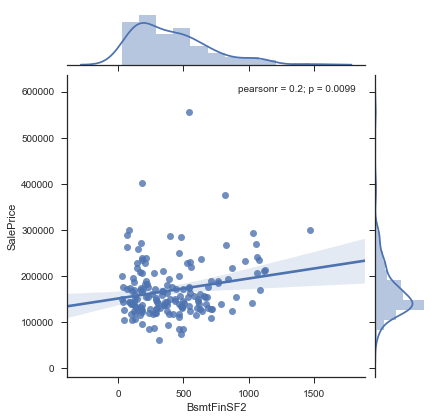

In [73]:
temp_df = sml.train[sml.train['BsmtFinSF2'] > 0]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='BsmtFinSF2', y="SalePrice", data=temp_df, kind="reg") 

BsmtFinSF2 without 0 now seems to be highly related to the SalePrice, (r=.2)

conclusion: ** keep the BsmtFinSF2**

### check **LowQualFinSF**

> same reason as BstmFinSF2, we have to focus on LowQualFinSF > 0

check precentage = 1.781 %


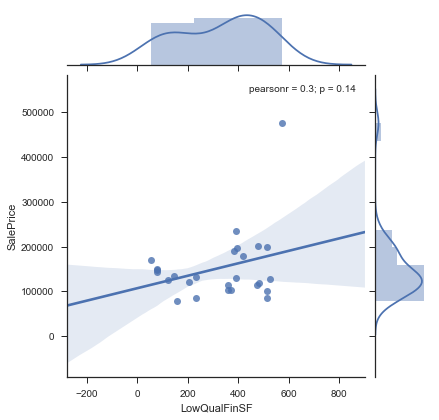

In [74]:
temp_df = sml.train[sml.train['LowQualFinSF'] > 0]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='LowQualFinSF', y="SalePrice", data=temp_df, kind="reg") 

LowQualFinSF without 0 now seems to be highly related to the SalePrice, (r=.3)
There is one outlier, which compose 1/1460 ~= 0.0685 % of the data => upper = 99.93

conclusion: ** keep the LowQualFinSF but remove one outlier (~upper = 99.93)**

### check **BsmtHalfBath**

check precentage = 100.000 %


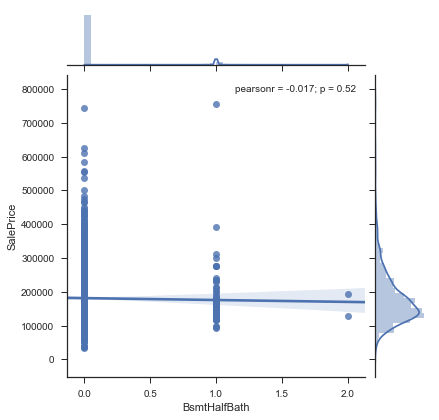

In [75]:
temp_df = sml.train[sml.train['BsmtHalfBath'] > -1]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='BsmtHalfBath', y="SalePrice", data=temp_df, kind="reg") 

BsmtHalfBath = 2 seems to restrain the range of SalePrice, which could be still informative. 

conclusion: ** keep the BsmtHalfBath**

### check **KitchenAbvGr**

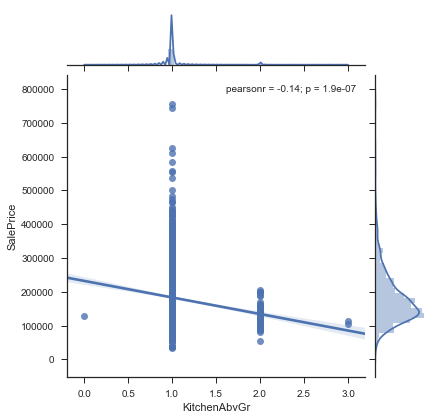

In [76]:
sns.jointplot(x='KitchenAbvGr', y="SalePrice", data=sml.train, kind="reg") 

same reason as BsmtHalfBath

conclusion: ** keep the KitchenAbvGr**

### check **EnclosedPorch**

> same reason as BstmFinSF2, we have to focus on EnclosedPorch > 0

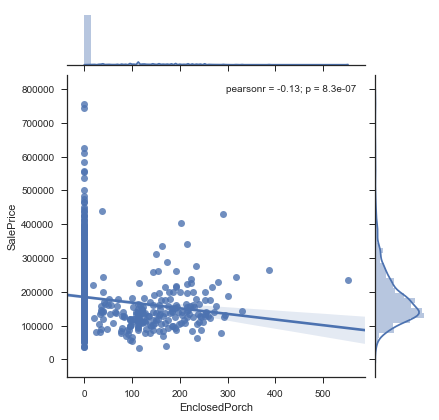

In [77]:
sns.jointplot(x='EnclosedPorch', y="SalePrice", data=sml.train, kind="reg") 

check precentage = 14.247 %


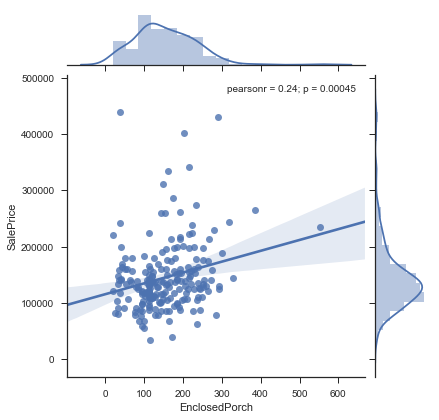

In [78]:
temp_df = sml.train[sml.train['EnclosedPorch'] > 0]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='EnclosedPorch', y="SalePrice", data=temp_df, kind="reg") 

Wow, the seemingly outlier almost follows the linear relationsip from the above.

conclusion: ** keep the EnclosedPorch**

### check **3SsnPorch**

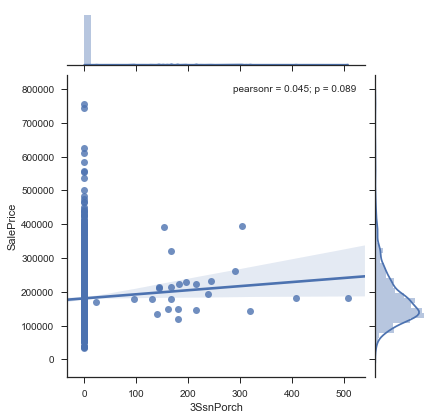

In [79]:
sns.jointplot(x='3SsnPorch', y="SalePrice", data=sml.train, kind="reg") 

focus on 3SsnPorch > 200

check precentage = 0.616 %


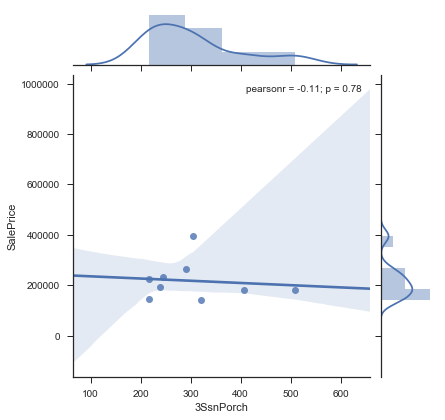

In [80]:
temp_df = sml.train[sml.train['3SsnPorch'] > 200]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='3SsnPorch', y="SalePrice", data=temp_df, kind="reg") 

it seems that having too much 3SsnPorch area have a slightly negative effect on the SalePrice, hmm...

The outlier almost follows the linear relationsip from the above.

conclusion: ** keep the 3SsnPorch**

### check **ScreenPorch**

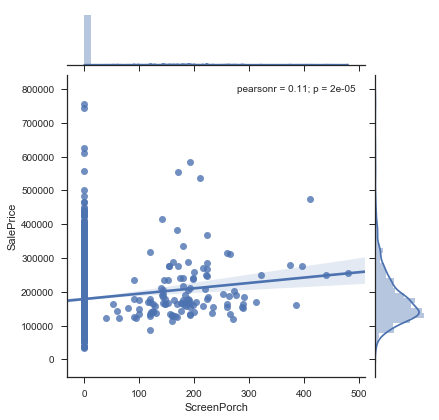

In [81]:
sns.jointplot(x='ScreenPorch', y="SalePrice", data=sml.train, kind="reg") 

ok, nice then. seemingly outliers follow the positive relationship

conclusion: ** keep the 3SsnPorch**

### check **PoolArea**

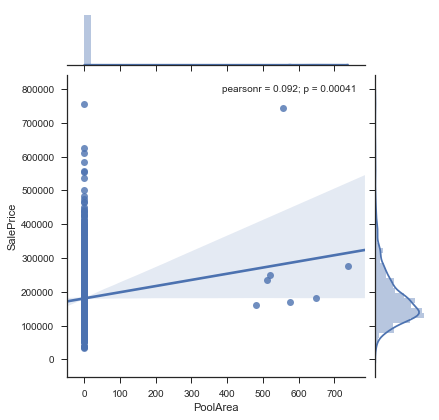

In [82]:
sns.jointplot(x='PoolArea', y="SalePrice", data=sml.train, kind="reg") 

focus on PoolArea > 400

check precentage = 0.479 %


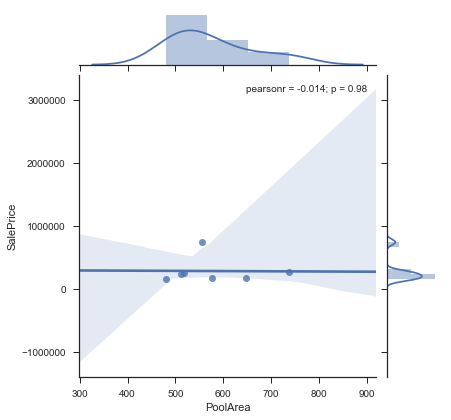

In [83]:
temp_df = sml.train[sml.train['PoolArea'] > 400]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='PoolArea', y="SalePrice", data=temp_df, kind="reg") 

the seemingly outliers seems to restrain the SalePrice to around 25000, if there are pools!

conclusion: ** keep the PoolArea**

### check **MiscVal**

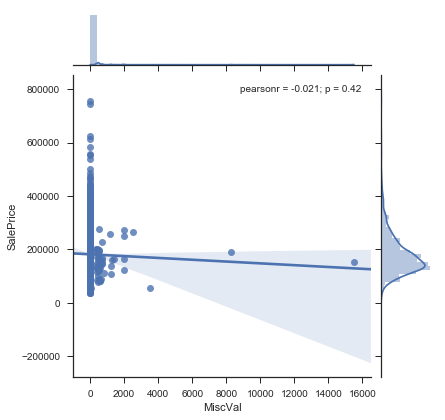

In [84]:
sns.jointplot(x='MiscVal', y="SalePrice", data=sml.train, kind="reg") 

ok, nice then. seemingly outliers follow the slightly negative relationship

conclusion: ** keep the MisVal**

Observe from the distribution above, we can assume whether there might be outliers or not

* LotArea: Lot size in square feet
* BsmtFinSF2: Type 2 finished square feet 
* LowQualFinSF: Low quality finished square feet (all floors)  
* BsmtHalfBath: Basement half bathrooms 
* KitchenAbvGr: Total rooms above grade (does not include bathrooms) 
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* MiscVal: $Value of miscellaneous feature

this function removes the outliers (upper) and draw the continuous plot before and after the removal


In [85]:
def plot_outliers(outlier_dict):
    for col in outlier_dict:
        sml.plot.continuous(col)
        sml.feature.outliers(col, upper=outlier_dict[col])
        sml.plot.continuous(col)

"\noutlier_dict = {\n    'LotArea'       :  99.5,\n    'BsmtFinSF2'    :  99 ,   \n    'LowQualFinSF'  :  99.93,\n    'BsmtHalfBath'  :  99,\n    'KitchenAbvGr'  :  99,\n    'EnclosedPorch' :  99,\n    '3SsnPorch'     :  99,\n    'ScreenPorch'   :  99,\n    'PoolArea'      :  99,\n    'MiscVal'       :  99,\n}\n"

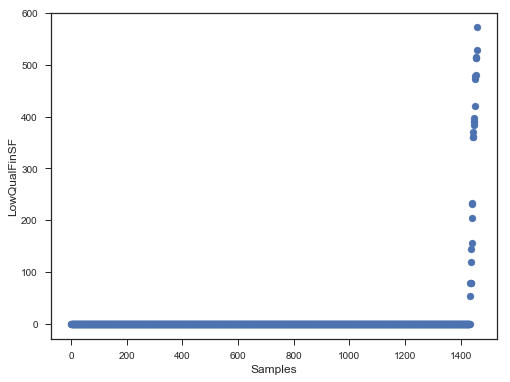

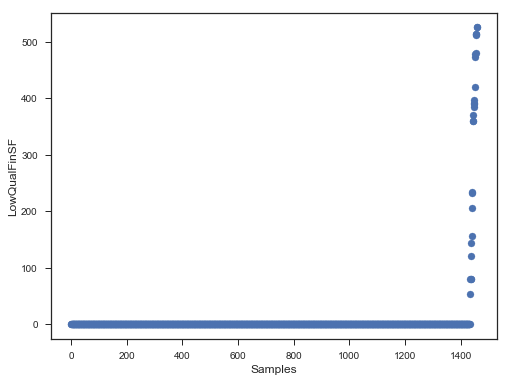

In [86]:

outlier_dict = {
    'LowQualFinSF'  :  99.92,
}
'''
outlier_dict = {
    'LotArea'       :  99.5,
    'BsmtFinSF2'    :  99 ,   
    'LowQualFinSF'  :  99.93,
    'BsmtHalfBath'  :  99,
    'KitchenAbvGr'  :  99,
    'EnclosedPorch' :  99,
    '3SsnPorch'     :  99,
    'ScreenPorch'   :  99,
    'PoolArea'      :  99,
    'MiscVal'       :  99,
}
'''

plot_outliers(outlier_dict)


# Feature Engineering

In [87]:
# copy the train\test data
final_train = sml.train
final_test = sml.test

eda_result_df = sml.eda()
eda_result_df

,Results,Observations
Speedml Release,v0.9.3,Visit https://speedml.com for release notes.
Outliers Upper,"[LotArea, BsmtFinSF2, LowQualFinSF, BsmtHalfBa...",Positive skew (> 3). Use feature.outliers(upper).
Shape,"train (1460, 80) | test (1459, 79)",
Numerical Ratio,46%,Aim for 100% numerical.
Numerical High-cardinality,"[LotFrontage, LotArea, YearBuilt, YearRemodAdd...",(>30) categories. Use feature.density
Numerical Categorical,"[MSSubClass, OverallQual, OverallCond, LowQual...",Use plot.ordinal.
Text Categorical,"[Fence, FireplaceQu, CentralAir, MiscFeature, ...",Use feature.labels or feature.mapping.
Target Analysis (SalePrice),Pre-process.,Dimensionality reduction?


In [88]:
def update_final_df(is_train, col_name, data):
    if is_train is True:
        final_train[col_name] = data
    else:
        final_test[col_name] = data

## Numerical Types

> ## Categorical: Deal with empty values

In [89]:
cat_num_col = eda_result_df['Results'][5]
print(np.isnan(sml.train[cat_num_col]).sum())
print(sml.train[cat_num_col].isnull().sum())
print(np.isnan(sml.test[cat_num_col]).sum())
print(sml.test[cat_num_col].isnull().sum())

MSSubClass      0
OverallQual     0
OverallCond     0
LowQualFinSF    0
BsmtFullBath    0
BsmtHalfBath    0
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageCars      0
3SsnPorch       0
PoolArea        0
MiscVal         0
MoSold          0
YrSold          0
dtype: int64
MSSubClass      0
OverallQual     0
OverallCond     0
LowQualFinSF    0
BsmtFullBath    0
BsmtHalfBath    0
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageCars      0
3SsnPorch       0
PoolArea        0
MiscVal         0
MoSold          0
YrSold          0
dtype: int64
MSSubClass      0
OverallQual     0
OverallCond     0
LowQualFinSF    0
BsmtFullBath    2
BsmtHalfBath    2
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageCars      1
3SsnPorch       0
PoolArea        0
MiscVal         0
MoSold          0
YrSold          0
dt

fortunately, we don't have any null values for cat. numerical type

> ## High cardinality num: Deal with empty values, and do some value transform if needed

* I assumed that all the features are normally distributed, hence all empty values are then replaced with the mean, then
* I'll have them normalized with mean = 0, var=1 to ease the learning

In [90]:
high_card_num_col = eda_result_df['Results'][4]
high_card_num_col

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'SalePrice']

In [91]:
def replace_null_col_data(col_data, new_value):
    new_col = col_data
    new_col[new_col.isnull()] = new_value
    return new_col

we assume the test data and the train data should be comes from the same distribution, hence, the mean\var are calculated based on both training data set.

In [92]:
def deal_with_null_value(df, col_list, is_train):
    for col in col_list:
        null_count = df[col].isnull().sum()
        if null_count != 0:
            print('Total null counts for feature {}: {}'.format(col, null_count))
            
            mean_val = sml.train[col].mean()
            print('Mean used to replace', sml.train[col].mean())

            new_col = replace_null_col_data(df[col], mean_val)
            update_final_df(is_train, col, new_col)
            print(new_col.isnull().sum())

In [93]:
deal_with_null_value(sml.train, high_card_num_col, True)

Total null counts for feature LotFrontage: 259
Mean used to replace 70.04995836802665
0

C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()



Total null counts for feature MasVnrArea: 8
Mean used to replace 103.68526170798899
0
Total null counts for feature GarageYrBlt: 81
Mean used to replace 1978.5061638868744
0


In [94]:
high_card_num_col_no_saleprice = [col for col in high_card_num_col if col != 'SalePrice']
deal_with_null_value(sml.test, high_card_num_col_no_saleprice, False)

Total null counts for feature LotFrontage: 227
Mean used to replace

C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


 70.04995836802642
0
Total null counts for feature MasVnrArea: 15
Mean used to replace 103.68526170798896
0
Total null counts for feature BsmtFinSF1: 1
Mean used to replace 443.6397260273973
0
Total null counts for feature BsmtFinSF2: 1
Mean used to replace 46.54931506849315
0
Total null counts for feature BsmtUnfSF: 1
Mean used to replace 567.2404109589041
0
Total null counts for feature TotalBsmtSF: 1
Mean used to replace 1057.4294520547944
0
Total null counts for feature GarageYrBlt: 78
Mean used to replace 1978.5061638868744
0
Total null counts for feature GarageArea: 1
Mean used to replace 472.9801369863014
0


> final check to see if any missing null values not dealt with

In [95]:
print(final_train[high_card_num_col].isnull().sum())
print(final_test[high_card_num_col_no_saleprice].isnull().sum())


LotFrontage      0
LotArea          0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
GarageYrBlt      0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
ScreenPorch      0
SalePrice        0
dtype: int64
LotFrontage      0
LotArea          0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
GarageYrBlt      0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
ScreenPorch      0
dtype: int64


In [96]:
print(high_card_num_col_no_saleprice)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


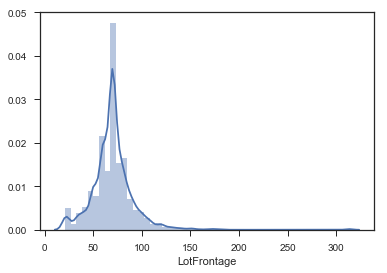

In [104]:
sns.distplot(sml.train['LotFrontage'])

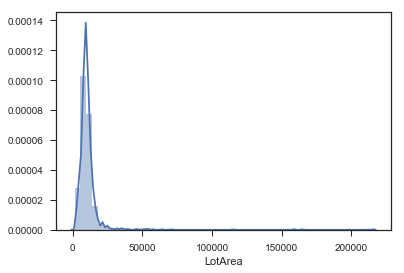

In [105]:
sns.distplot(sml.train['LotArea'])

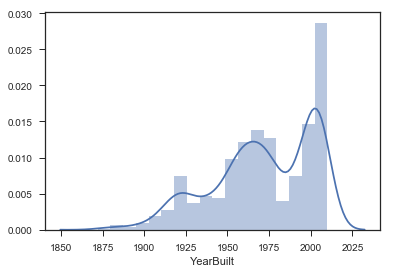

In [112]:
sns.distplot(sml.train['YearBuilt'])

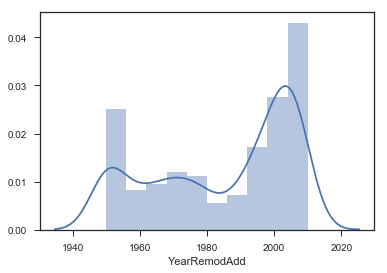

In [107]:
sns.distplot(sml.train['YearRemodAdd'])

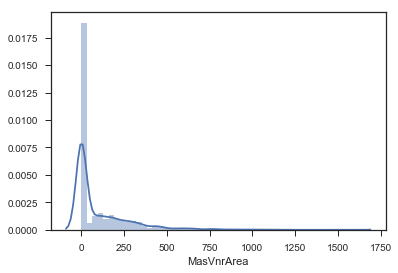

In [108]:
sns.distplot(sml.train['MasVnrArea'])

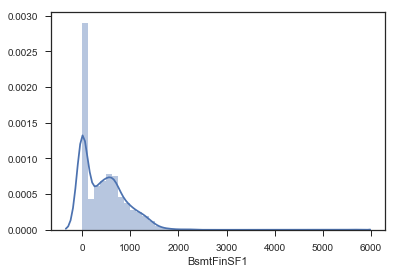

In [109]:
sns.distplot(sml.train['BsmtFinSF1'])

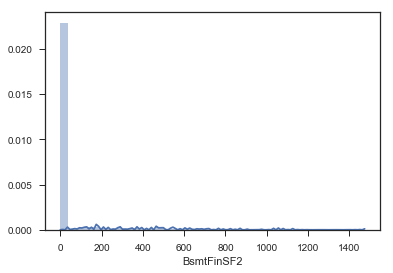

In [113]:
sns.distplot(sml.train['BsmtFinSF2'])

In [62]:
for col in high_card_num_col_no_saleprice:
    mean = sml.train[col].mean()
    stddev = sml.train[col].std()
    print('===================================================')
    print('train col {} => mean={:.3f}, var={:.3f}'.format(col, mean, stddev))
    final_train[col] = (final_train[col] - mean) / stddev
    final_test[col] = (final_test[col] - mean) / stddev
    print('train mean\dev = {:.3f}\\{:.3f}'.format(final_train[col].mean(), final_train[col].std()))
    print('test mean\dev = {:.3f}\\{:.3f}'.format(final_test[col].mean(), final_test[col].std()))


train col LotFrontage => mean=70.050, var=22.024
train mean\dev = 0.000\1.000
test mean\dev = -0.056\0.934
train col LotArea => mean=10516.828, var=9981.265
train mean\dev = -0.000\1.000
test mean\dev = -0.070\0.496
train col YearBuilt => mean=1971.268, var=30.203
train mean\dev = 0.000\1.000
test mean\dev = 0.003\1.006
train col YearRemodAdd => mean=1984.866, var=20.645
train mean\dev = 0.000\1.000
test mean\dev = -0.058\1.023
train col MasVnrArea => mean=103.685, var=180.569
train mean\dev = 0.000\1.000
test mean\dev = -0.016\0.979
train col BsmtFinSF1 => mean=443.640, var=456.098
train mean\dev = -0.000\1.000
test mean\dev = -0.010\0.998
train col BsmtFinSF2 => mean=46.549, var=161.319
train mean\dev = -0.000\1.000
test mean\dev = 0.038\1.095
train col BsmtUnfSF => mean=567.240, var=441.867
train mean\dev = -0.000\1.000
test mean\dev = -0.029\0.989
train col TotalBsmtSF => mean=1057.429, var=438.705
train mean\dev = 0.000\1.000
test mean\dev = -0.026\1.009
train col 1stFlrSF => mean

> create density features for all numerical cols with high card. num.

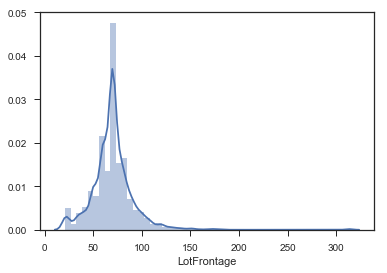

In [116]:
sns.distplot(sml.train['LotFrontage'])

In [117]:
sml.feature.impute()
eda_result_df = sml.eda()
eda_result_df

'Imputed 6617 empty values to 0.'

,Results,Observations
Speedml Release,v0.9.3,Visit https://speedml.com for release notes.
Outliers Upper,"[LotArea, BsmtFinSF2, LowQualFinSF, BsmtHalfBa...",Positive skew (> 3). Use feature.outliers(upper).
Shape,"train (1460, 80) | test (1459, 79)",
Numerical Ratio,46%,Aim for 100% numerical.
Numerical High-cardinality,"[LotFrontage, LotArea, YearBuilt, YearRemodAdd...",(>30) categories. Use feature.density
Numerical Categorical,"[MSSubClass, OverallQual, OverallCond, LowQual...",Use plot.ordinal.
Text Categorical,"[Electrical, Neighborhood, PoolQC, Functional,...",Use feature.labels or feature.mapping.
Target Analysis (SalePrice),Pre-process.,Dimensionality reduction?


In [118]:
high_card_num_col = eda_result_df['Results'][4]
df = pd.DataFrame ({
            'col name': high_card_num_col, 
            'type': [sml.train[col].dtype for col in high_card_num_col],
            'r-val': [pearsonr(sml.train[col], sml.train['SalePrice'])[0] for col in high_card_num_col]
        })
df

,col name,r-val,type
0,LotFrontage,0.334901,float64
1,LotArea,0.263843,int64
2,YearBuilt,0.522897,int64
3,YearRemodAdd,0.507101,int64
4,MasVnrArea,0.475241,float64
5,BsmtFinSF1,0.386420,float64
6,BsmtFinSF2,-0.011378,float64
7,BsmtUnfSF,0.214479,float64
8,TotalBsmtSF,0.613581,float64
9,1stFlrSF,0.605852,int64


In [119]:
'''
for col in high_card_num_col:
    if col != 'SalePrice':
        sml.feature.density(col)
'''    

"\nfor col in high_card_num_col:\n    if col != 'SalePrice':\n        sml.feature.density(col)\n"

In [120]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 25

## Category text 

In [121]:
text_cat_col = eda_result_df['Results'][6]
print(len(text_cat_col))
sml.train[text_cat_col].head(25)

43


,Electrical,Neighborhood,PoolQC,Functional,BldgType,FireplaceQu,BsmtExposure,GarageQual,CentralAir,LandSlope,SaleCondition,Utilities,Heating,GarageCond,Fence,LotShape,RoofStyle,SaleType,RoofMatl,ExterQual,BsmtCond,Condition2,Condition1,ExterCond,MSZoning,PavedDrive,BsmtFinType2,LandContour,GarageFinish,MiscFeature,Exterior1st,Exterior2nd,HeatingQC,BsmtQual,Alley,Foundation,MasVnrType,LotConfig,BsmtFinType1,GarageType,KitchenQual,Street,HouseStyle
0,SBrkr,CollgCr,Gd,Typ,1Fam,Gd,No,TA,Y,Gtl,Normal,AllPub,GasA,TA,MnPrv,Reg,Gable,WD,CompShg,Gd,TA,Norm,Norm,TA,RL,Y,Unf,Lvl,RFn,Shed,VinylSd,VinylSd,Ex,Gd,Grvl,PConc,BrkFace,Inside,GLQ,Attchd,Gd,Pave,2Story
1,SBrkr,Veenker,Gd,Typ,1Fam,TA,Gd,TA,Y,Gtl,Normal,AllPub,GasA,TA,MnPrv,Reg,Gable,WD,CompShg,TA,TA,Norm,Feedr,TA,RL,Y,Unf,Lvl,RFn,Shed,MetalSd,MetalSd,Ex,Gd,Grvl,CBlock,None,FR2,ALQ,Attchd,TA,Pave,1Story
2,SBrkr,CollgCr,Gd,Typ,1Fam,TA,Mn,TA,Y,Gtl,Normal,AllPub,GasA,TA,MnPrv,IR1,Gable,WD,CompShg,Gd,TA,Norm,Norm,TA,RL,Y,Unf,Lvl,RFn,Shed,VinylSd,VinylSd,Ex,Gd,Grvl,PConc,BrkFace,Inside,GLQ,Attchd,Gd,Pave,2Story
3,SBrkr,Crawfor,Gd,Typ,1Fam,Gd,No,TA,Y,Gtl,Abnorml,AllPub,GasA,TA,MnPrv,IR1,Gable,WD,CompShg,TA,Gd,Norm,Norm,TA,RL,Y,Unf,Lvl,Unf,Shed,Wd Sdng,Wd Shng,Gd,TA,Grvl,BrkTil,None,Corner,ALQ,Detchd,Gd,Pave,2Story
4,SBrkr,NoRidge,Gd,Typ,1Fam,TA,Av,TA,Y,Gtl,Normal,AllPub,GasA,TA,MnPrv,IR1,Gable,WD,CompShg,Gd,TA,Norm,Norm,TA,RL,Y,Unf,Lvl,RFn,Shed,VinylSd,VinylSd,Ex,Gd,Grvl,PConc,BrkFace,FR2,GLQ,Attchd,Gd,Pave,2Story
5,SBrkr,Mitchel,Gd,Typ,1Fam,Gd,No,TA,Y,Gtl,Normal,AllPub,GasA,TA,MnPrv,IR1,Gable,WD,CompShg,TA,TA,Norm,Norm,TA,RL,Y,Unf,Lvl,Unf,Shed,VinylSd,VinylSd,Ex,Gd,Grvl,Wood,None,Inside,GLQ,Attchd,TA,Pave,1.5Fin
6,SBrkr,Somerst,Gd,Typ,1Fam,Gd,Av,TA,Y,Gtl,Normal,AllPub,GasA,TA,MnPrv,Reg,Gable,WD,CompShg,Gd,TA,Norm,Norm,TA,RL,Y,Unf,Lvl,RFn,Shed,VinylSd,VinylSd,Ex,Ex,Grvl,PConc,Stone,Inside,GLQ,Attchd,Gd,Pave,1Story
7,SBrkr,NWAmes,Gd,Typ,1Fam,TA,Mn,TA,Y,Gtl,Normal,AllPub,GasA,TA,MnPrv,IR1,Gable,WD,CompShg,TA,TA,Norm,PosN,TA,RL,Y,BLQ,Lvl,RFn,Shed,HdBoard,HdBoard,Ex,Gd,Grvl,CBlock,Stone,Corner,ALQ,Attchd,TA,Pave,2Story
8,FuseF,OldTown,Gd,Min1,1Fam,TA,No,Fa,Y,Gtl,Abnorml,AllPub,GasA,TA,MnPrv,Reg,Gable,WD,CompShg,TA,TA,Norm,Artery,TA,RM,Y,Unf,Lvl,Unf,Shed,BrkFace,Wd Shng,Gd,TA,Grvl,BrkTil,None,Inside,Unf,Detchd,TA,Pave,1.5Fin
9,SBrkr,BrkSide,Gd,Typ,2fmCon,TA,No,Gd,Y,Gtl,Normal,AllPub,GasA,TA,MnPrv,Reg,Gable,WD,CompShg,TA,TA,Artery,Artery,TA,RL,Y,Unf,Lvl,RFn,Shed,MetalSd,MetalSd,Ex,TA,Grvl,BrkTil,None,Corner,GLQ,Attchd,TA,Pave,1.5Unf


> convert text with category type into numerical labels

In [122]:
for col in text_cat_col:
    sml.feature.labels([col])

In [123]:
sml.eda()

,Results,Observations
Speedml Release,v0.9.3,Visit https://speedml.com for release notes.
Outliers Upper,"[LotArea, Alley, Utilities, LandSlope, Conditi...",Positive skew (> 3). Use feature.outliers(upper).
Outliers Lower,"[Street, LandContour, BsmtCond, BsmtFinType2, ...",Negative skew (< -3). Use feature.outliers(low...
Shape,"train (1460, 80) | test (1459, 79)",
Numerical High-cardinality,"[LotFrontage, LotArea, YearBuilt, YearRemodAdd...",(>30) categories. Use feature.density
Numerical Categorical,"[MSSubClass, MSZoning, Street, Alley, LotShape...",Use plot.ordinal.
Target Analysis (SalePrice),Pre-process.,Dimensionality reduction?


In [124]:
sml.train.head(20)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.000000,8450,1,0,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706.0,5,0.0,150.0,856.0,1,0,1,4,856,854,0.0,1710,1.0,0.0,2,1,3,1,2,8,6,0,2,1,2003.0,1,2.0,548.0,4,4,2,0,61,0,0,0,0,2,2,2,0,2,2008,8,4,208500
1,20,3,80.000000,9600,1,0,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978.0,5,0.0,284.0,1262.0,1,0,1,4,1262,0,0.0,1262,0.0,1.0,2,0,3,1,3,6,6,1,4,1,1976.0,1,2.0,460.0,4,4,2,298,0,0,0,0,0,2,2,2,0,5,2007,8,4,181500
2,60,3,68.000000,11250,1,0,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486.0,5,0.0,434.0,920.0,1,0,1,4,920,866,0.0,1786,1.0,0.0,2,1,3,1,2,6,6,1,4,1,2001.0,1,2.0,608.0,4,4,2,0,42,0,0,0,0,2,2,2,0,9,2008,8,4,223500
3,70,3,60.000000,9550,1,0,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216.0,5,0.0,540.0,756.0,1,2,1,4,961,756,0.0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,5,1998.0,2,3.0,642.0,4,4,2,0,35,272,0,0,0,2,2,2,0,2,2006,8,0,140000
4,60,3,84.000000,14260,1,0,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655.0,5,0.0,490.0,1145.0,1,0,1,4,1145,1053,0.0,2198,1.0,0.0,2,1,4,1,2,9,6,1,4,1,2000.0,1,3.0,836.0,4,4,2,192,84,0,0,0,0,2,2,2,0,12,2008,8,4,250000
5,50,3,85.000000,14115,1,0,0,3,0,4,0,11,2,2,0,0,5,5,1993,1995,1,1,12,13,2,0.0,3,4,5,2,3,3,2,732.0,5,0.0,64.0,796.0,1,0,1,4,796,566,0.0,1362,1.0,0.0,1,1,1,1,3,5,6,0,2,1,1993.0,2,2.0,480.0,4,4,2,40,30,0,320,0,0,2,2,2,700,10,2009,8,4,143000
6,20,3,75.000000,10084,1,0,3,3,0,4,0,21,2,2,0,2,8,5,2004,2005,1,1,12,13,3,186.0,2,4,2,0,3,0,2,1369.0,5,0.0,317.0,1686.0,1,0,1,4,1694,0,0.0,1694,1.0,0.0,2,0,3,1,2,7,6,1,2,1,2004.0,1,2.0,636.0,4,4,2,255,57,0,0,0,0,2,2,2,0,8,2007,8,4,307000
7,60,3,70.049958,10382,1,0,0,3,0,0,0,14,4,2,0,5,7,6,1973,1973,1,1,6,6,3,240.0,3,4,1,2,3,2,0,859.0,1,32.0,216.0,1107.0,1,0,1,4,1107,983,0.0,2090,1.0,0.0,2,1,3,1,3,7,6,2,4,1,1973.0,1,2.0,484.0,4,4,2,235,204,228,0,0,0,2,2,2,350,11,2009,8,4,200000
8,50,4,51.000000,6120,1,0,3,3,0,4,0,17,0,2,0,0,7,5,1931,1950,1,1,3,15,2,0.0,3,4,0,3,3,3,5,0.0,5,0.0,952.0,952.0,1,2,1,1,1022,752,0.0,1774,0.0,0.0,2,0,2,2,3,8,2,2,4,5,1931.0,2,2.0,468.0,1,4,2,90,0,205,0,0,0,2,2,2,0,4,2008,8,0,129900
9,190,3,50.000000,7420,1,0,3,3,0,0,0,3,0,0,1,1,5,6,1939,1950,1,1,8,8,2,0.0,3,4,0,3,3,3,2,851.0,5,0.0,140.0,991.0,1,0,1,4,1077,0,0.0,1077,1.0,0.0,1,0,2,2,3,5,6,2,4,1,1939.0,1,1.0,205.0,2,4,2,0,4,0,0,0,0,2,2,2,0,1,2008,8,4,118000


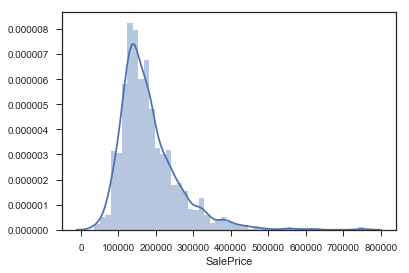

In [125]:
sns.distplot(sml.train['SalePrice'])

# Use DNN to train with multiple features

* Use Adam
* Xavier initialization
* Drop

In [126]:
#train = sml.train
#test = sml.test

train = pd.read_csv('input/processed_train.csv')
test = pd.read_csv('input/processed_test.csv')

print(train.head(3))
print(test.head(3))

   MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0          60         3         65.0     8450       1      0         3   
1          20         3         80.0     9600       1      0         3   
2          60         3         68.0    11250       1      0         0   

   LandContour  Utilities  LotConfig  LandSlope  Neighborhood  Condition1  \
0            3          0          4          0             5           2   
1            3          0          2          0            24           1   
2            3          0          4          0             5           2   

   Condition2  BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  \
0           2         0           5            7            5       2003   
1           2         0           2            6            8       1976   
2           2         0           5            7            5       2001   

   YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  \
0          

KeyboardInterrupt: 

In [ ]:
train_x = train[[col for col in train.columns if col != 'SalePrice']]
train_y = np.log(train['SalePrice']).values.reshape(train_x.shape[0], 1)

train_length = int(len(train_x)*.7)
valid_x = train_x.iloc[train_length:,:]
valid_y = train_y[train_length:,:]

#train_x = train_x.iloc[:train_length,:]
#train_y = train_y[:train_length,:]

train_x = train_x.T
train_y = train_y.T
valid_x = valid_x.T
valid_y = valid_y.T

test_x = test.T

print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape)

In [ ]:
import math
from time import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from IPython.display import clear_output, Image, display, HTML
from tensorflow.python.client import timeline

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None), name='X')
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name='Y')
    phase = tf.placeholder(tf.bool, name='phase')
    
    return X, Y, phase

def initialize_parameters( n_feature, n_output,
    layer_count = 3, hidden_neuron = [25, 12]):
       
    W = []
    b = []

    for i in range(layer_count):
        weight_str = 'W'+str(i+1)
        bias_str = 'b'+str(i+1)

        if i == 0:
            weight = tf.get_variable(weight_str, [hidden_neuron[i], n_feature], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            bias = tf.get_variable(bias_str, [hidden_neuron[i], 1], initializer = tf.zeros_initializer())
        elif i == layer_count - 1:
            weight = tf.get_variable(weight_str, [n_output, hidden_neuron[i-1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            bias = tf.get_variable(bias_str, [n_output, 1], initializer = tf.zeros_initializer())
        else:
            weight = tf.get_variable(weight_str, [hidden_neuron[i], hidden_neuron[i-1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            bias = tf.get_variable(bias_str, [hidden_neuron[i], 1], initializer = tf.zeros_initializer())
            
        W.append(weight)
        b.append(bias)

    parameters = {
        'W': W,
        'b': b
    }

    return parameters

def batch_norm(x, n_out, phase_train, bn_decay_rate):
    """
    Batch normalization on convolutional maps.
    Ref.: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope('bn'):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=bn_decay_rate)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed
    
def forward_propagation(X, parameters, is_training, bn_decay_rate):

    W = parameters['W']
    b = parameters['b']
    
    for i in range(len(W)):
        weight = W[i]
        bias = b[i]
        scope = 'layer' + str(i+1)
        with tf.variable_scope(scope):
            if i == 0:
                output = tf.matmul(weight, X) + bias
                output = tf.transpose(output, name='transpose_to')
                output = batch_norm(output, output.get_shape()[1], is_training, bn_decay_rate)
                output = tf.transpose(output, name='transpose_back')
                activation = tf.nn.relu(output)
            elif i == len(W)-1:
                output = tf.matmul(weight, activation) + bias
            else:
                output = tf.matmul(weight, activation) + bias
                output = tf.transpose(output, name='transpose_to')
                output = batch_norm(output, output.get_shape()[1], is_training, bn_decay_rate)
                output = tf.transpose(output, name='transpose_back')
                activation = tf.nn.relu(output)

    return output

def compute_cost(parameters, output, Y, l2_loss_weight):

    with tf.name_scope('loss'):
        loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(Y, output))))
        l2_loss = tf.add_n([tf.nn.l2_loss(w) for w in parameters['W']]) * l2_loss_weight
        
        loss = tf.reduce_mean(loss + l2_loss_weight)
        
        return loss
        
    raise ValueError('Cannot enter scope \"loss \"')
    
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X.iloc[:, permutation]
    shuffled_Y = Y[:,permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X.iloc[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X.iloc[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches
    
def model(X_train, Y_train, 
        X_valid, Y_valid,
        X_test,
        learning_rate = 0.01,
        lr_decay_step = 10000,
        lr_decay_rate = 0.95,
        bn_decay_rate = 0.9,
        l2_loss_weight = 0.01,
        num_epochs = 1500, 
        minibatch_size = 32, 
        print_cost = True, 
        layer_count = 3, 
        hidden_neuron = [25, 12],
        profiling = False):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y, phase = create_placeholders(n_x, n_y)

    # Initialize parameters
    # n_feature, n_output,
    # layer_count = 3, hidder_neuron = [25, 12]
    parameters = initialize_parameters(n_x, n_y, layer_count = layer_count, hidden_neuron = hidden_neuron)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    output = forward_propagation(X, parameters, phase, bn_decay_rate)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(parameters, output, Y, l2_loss_weight)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    global_step = tf.Variable(0, trainable=False)
    online_learning_rate = tf.train.exponential_decay(learning_rate, global_step,
                                           lr_decay_step, lr_decay_rate, staircase=True)
    
    # Note: when training, the moving_mean and moving_variance need to be updated. 
    # By default the update ops are placed in tf.GraphKeys.UPDATE_OPS, 
    # so they need to be added as a dependency to the train_op
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):                                       
        optimizer = tf.train.AdamOptimizer(learning_rate = online_learning_rate).minimize(cost, global_step=global_step)
      
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # show graph
    show_graph(tf.get_default_graph().as_graph_def())
    
    # Calculate the correct predictions
    rmse = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(Y, output))))

    # Calculate accuracy on the test set
    rmse = tf.cast(rmse, "float")
    
    # add for time usage prediction
    start_time = 0
    
    # Start the session to compute the tensorflow graph
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
            
        # Run the initialization
        sess.run(init)
        
        if profiling is True:
            run_metadata = tf.RunMetadata()
            _ , all_cost = sess.run([optimizer, cost], 
                        feed_dict={X: X_train, Y: Y_train, phase:True},
                        options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE),
                        run_metadata=run_metadata)
            trace = timeline.Timeline(step_stats=run_metadata.step_stats)
            trace_file = open('timeline.ctf.json', 'w')
            trace_file.write(trace.generate_chrome_trace_format())
            
        else:
            # Do the training loop
            for epoch in range(num_epochs):

                if epoch == 0:
                    start_time = time()

                epoch_cost = 0.                       # Defines a cost related to an epoch
                num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
                seed = seed + 1
                minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

                for minibatch in minibatches:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch

                    # IMPORTANT: The line that runs the graph on a minibatch.
                    # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                    if profiling is False:
                        _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, phase:True})
                    else:
                        _ , minibatch_cost = sess.run([optimizer, cost], 
                            feed_dict={X: minibatch_X, Y: minibatch_Y, phase:True},
                            options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE),
                            run_metadata=run_metadata)

                    epoch_cost += minibatch_cost / num_minibatches

                # Print the cost every 100 epoch
                if print_cost == True and (epoch+1) % 100 == 0:
                    duration = int(time() - start_time)
                    remain_epoch = num_epochs - epoch
                    remain_epoch_round = int(remain_epoch/100)
                    remain_time = remain_epoch_round*duration
                    remain_hour = int(remain_time/3600)
                    remain_minute = int((remain_time - remain_hour*3600) / 60)
                    remain_second = int(remain_time - remain_hour*3600 - remain_minute*60)

                    valid_set_error = rmse.eval({X: X_valid, Y: Y_valid, phase:False})
                    print ("=======================================")
                    print ("Cost after %i epochs: %.5f" % (epoch+1, epoch_cost))
                    print ("Trainning set rmse:", rmse.eval({X: X_train, Y: Y_train, phase:False}))
                    print ("Validation set rmse:", valid_set_error)
                    print ("Remaining time: %d:%d:%d \n" % (remain_hour, remain_minute, remain_second))
                    start_time = time()

                    if epoch > 300:
                        costs.append(valid_set_error)

            # plot the cost
            plt.plot(np.squeeze(costs))
            plt.ylabel('validation set error')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

            # lets save the parameters in a variable
            parameters = sess.run(parameters)
            print ("Parameters have been trained!")

            final_output = sess.run(output, feed_dict={X: X_test, phase: False})
            print(final_output.shape)
            submission = pd.DataFrame({
                "Id": np.arange(final_output.shape[1]),
                "SalePrice": np.exp(final_output.reshape((final_output.shape[1],)))
            })
            submission.to_csv("submission.csv", encoding='utf-8', index=False)

            return parameters

In [ ]:
# model(X_train, Y_train, learning_rate = 0.0001,
# num_epochs = 1500, minibatch_size = 32, print_cost = True, layer_count = 3, hidder_neuron = [25, 12])

parameters = model(train_x, train_y, 
                   valid_x, valid_y,
                   test_x,
                   learning_rate= 0.001,
                   lr_decay_step = 5000,
                   lr_decay_rate = 1,
                   bn_decay_rate = 0.99,
                   l2_loss_weight = 0.01,
                   num_epochs = 20000, 
                   minibatch_size = 512,
                   layer_count = 4, 
                   hidden_neuron = [128, 256, 128],
                   profiling = False)


## Test #1
### Hyper-parameters:
* learning rate: 0.01
* learning rate decay: every 10000 steps => x0.95 
* l2_loss_weight = 0.01
* bn mean\var exp decay: 0.5
* minibatch_size = 64,
* layer_count = 10, 
* hidden_neuron = [100, 200, 400, 200, 200, 200, 100, 100, 50])
  
### Result:
* Cost after 100000 epochs: 0.12661
* Trainning set rmse: 0.101513
* Validation set rmse: 0.12882

## Test #2

### Hyper-parameters:
* learning rate: 0.001
* learning rate decay: every 10000 steps => x1 
* l2_loss_weight = 0.01
* bn mean\var exp decay: 0.9
* minibatch_size = 512,
* layer_count = 4, 
* hidden_neuron = [200, 400, 200])

### Result:
* Cost after 100000 epochs: 0.08824
* Trainning set rmse: 0.107606
* Validation set rmse: 0.195409 


## Test #3

### Hyper-parameters:
* learning rate: 0.001
* learning rate decay: every 10000 steps => x1 
* l2_loss_weight = 0.02
* bn mean\var exp decay: 0.9
* minibatch_size = 512,
* layer_count = 3, 
* hidden_neuron = [200, 400])

### Result:
* Cost after 100000 epochs: 0.12117
* Trainning set rmse: 0.117555
* Validation set rmse: 0.217021 


## Test #4

### Hyper-parameters:
* learning rate: 0.01
* learning rate decay: every 5000 steps => x.95
* l2_loss_weight = 0.001
* bn mean\var exp decay: 0.99
* minibatch_size = 256,
* layer_count = 10, 
* hidden_neuron = [100, 200, 200, 200, 200, 200, 100, 100, 50])

### Result:
* Cost after 100000 epochs: 
* Trainning set rmse: 
* Validation set rmse:  

# XG Boost

In [ ]:
from speedml import Speedml
sml = Speedml('input/train.csv', 
              'input/test.csv', 
              target = 'SalePrice',
              uid = 'Id')
sml.shape()

def plot_outliers(outlier_dict):
    for col in outlier_dict:
        sml.plot.continuous(col)
        sml.feature.outliers(col, upper=outlier_dict[col])
        sml.plot.continuous(col)
        
        
sml.configure('overfit_threshold',  sml.np.sqrt(sml.train.shape[0]) / sml.train.shape[0])
sml.configure('outpath',  "/")
sml.configure('high_cardinality',  30)

outlier_dict = {
    'LowQualFinSF'  :  99.92,
}

plot_outliers(outlier_dict)
sml.feature.impute()

eda_result_df = sml.eda()
print(eda_result_df)
text_cat_col = eda_result_df['Results'][6]
for col in text_cat_col:
    sml.feature.labels([col])
    
sml.model.data()

select_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
fixed_params = {'learning_rate': 0.1, 'subsample': 0.8, 
                'colsample_bytree': 0.8, 'seed':0, 
                'objective': 'binary:logistic'}

print(sml.xgb.hyper(select_params, fixed_params))

select_params = {'learning_rate': [0.3, 0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
fixed_params = {'max_depth': 3, 'min_child_weight': 1, 
                'colsample_bytree': 0.8, 'seed':0, 
                'objective': 'binary:logistic'}

print(sml.xgb.hyper(select_params, fixed_params))

tuned_params = {'learning_rate': 0.1, 'subsample': 0.7, 
                'max_depth': 3, 'min_child_weight': 1,
                'seed':0, 'colsample_bytree': 0.8, 
                'objective': 'binary:logistic'}
sml.xgb.cv(tuned_params)

tuned_params['n_estimators'] = sml.xgb.cv_results.shape[0] - 1
sml.xgb.params(tuned_params)

sml.xgb.classifier()
sml.model.evaluate()
sml.plot.model_ranks()
print(sml.model.ranks())
sml.xgb.fit()
sml.xgb.predict()
#sml.plot.xgb_importance()
sml.xgb.feature_selection()
sml.xgb.sample_accuracy()
sml.save_results(
    columns={ 'PassengerId': sml.uid,
             'Survived': sml.xgb.predictions }, 
    file_path='submission.csv'.format(sml.slug()))
sml.slug()